In [1]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
from pymatreader import read_mat
from scipy import sparse
import numpy as np
import os
from datetime import datetime, timedelta
import pandas
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
import cv2
import json
import pandas as pd
from amftrack.pipeline.paths.directory import *
from amftrack.util.sys import *
from amftrack.pipeline.functions.extract_observable import *
import pickle
from joblib import Parallel, delayed
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
directory = directory_project
update_analysis_info(directory)
analysis_info = get_current_analysis(directory)

In [3]:
# select = analysis_info.loc[analysis_info['PrincePos']==39]
select_v4 = analysis_info.loc[(analysis_info["version"] == "Version4")]
select_v3 = analysis_info.loc[(analysis_info["version"] == "Version3")]
select_v5 = analysis_info.loc[(analysis_info["version"] == "Version5")]
select_v6 = analysis_info.loc[(analysis_info["version"] == "Version6")]
select_v7 = analysis_info.loc[(analysis_info["version"] == "Version7")]
len(select_v7), select_v7.columns

(28,
 Index(['folder_analysis', 'version', 'Plate', 'PrincePos', 'root', 'strain',
        'medium', 'split', 'Temp', 'CrossDate', 'date', 'Pbait', 'date_begin',
        'date_end', 'number_timepoints', 'path_exp', 'path_analysis_info',
        'date_run_analysis'],
       dtype='object'))

In [7]:
select

,folder_analysis,version,Plate,PrincePos,root,strain,medium,split,Temp,CrossDate,date,Pbait,date_begin,date_end,number_timepoints,path_exp,path_analysis_info,date_run_analysis
0,Analysis_1635803385128979235_Version7,Version7,22,29,Carrot,A5,001P100N,Y,None,20210107,"12.01.2021, 11:20:",-,20210107_1119_Plate29,20210112_2320_Plate29,31,Analysis_1635803385128979235_Version7/experime...,Analysis_1635803385128979235_Version7/static_i...,"01.11.2021, 22:49:"
1,Analysis_1635804479124231336_Version7,Version7,808,35,Carrot,A5,001P100N,Y,None,20210928,"03.10.2021, 19:37:",-,20210929_0953_Plate35,20211011_1415_Plate35,91,Analysis_1635804479124231336_Version7/experime...,Analysis_1635804479124231336_Version7/static_i...,"01.11.2021, 23:07:"
8,Analysis_1635803775966705431_Version7,Version7,76,38,Carrot,A5,001P100N,Y,None,20210108,"10.01.2021, 11:44:",-,20210108_1143_Plate38,20210112_2337_Plate38,25,Analysis_1635803775966705431_Version7/experime...,Analysis_1635803775966705431_Version7/static_i...,"01.11.2021, 22:56:"
14,Analysis_1635803952870635797_Version7,Version7,26,39,Carrot,A5,001P100N,Y,None,20210104,"10.01.2021, 03:23:",-,20210106_1122_Plate30,20210113_2325_Plate30,44,Analysis_1635803952870635797_Version7/experime...,Analysis_1635803952870635797_Version7/static_i...,"01.11.2021, 22:59:"
17,Analysis_1635803530840438309_Version7,Version7,80,36,Carrot,A5,001P100N,Y,None,20201127,"03.12.2020, 09:55:",-,20201128_1802_Plate36,20201206_2113_Plate36,47,Analysis_1635803530840438309_Version7/experime...,Analysis_1635803530840438309_Version7/static_i...,"01.11.2021, 22:52:"
23,Analysis_1635803764989403054_Version7,Version7,799,39,Carrot,A5,001P100N,Y,None,20211001,"05.10.2021, 01:48:",-,20211001_1620_Plate39,20211011_1227_Plate39,95,Analysis_1635803764989403054_Version7/experime...,Analysis_1635803764989403054_Version7/static_i...,"01.11.2021, 22:56:"
32,Analysis_1635818336153685802_Version7,Version7,790,23,Carrot,A5,001P100N,Y,None,20210907,"07.09.2021, 15:07:",-,20210907_1108_Plate23,20210917_1325_Plate23,96,Analysis_1635818336153685802_Version7/experime...,Analysis_1635818336153685802_Version7/static_i...,"02.11.2021, 02:58:"
43,Analysis_1635816504415191310_Version7,Version7,800,31,Carrot,A5,001P100N,Y,None,20210928,"07.10.2021, 16:06:",-,20210929_0942_Plate31,20211011_1408_Plate31,91,Analysis_1635816504415191310_Version7/experime...,Analysis_1635816504415191310_Version7/static_i...,"02.11.2021, 02:28:"
58,Analysis_1635804634831318343_Version7,Version7,94,39,Carrot,A5,001P100N,Y,25,20201123,"24.11.2020, 12:02:",None,20201123_1253_Plate39,20201127_1613_Plate39,100,Analysis_1635804634831318343_Version7/experime...,Analysis_1635804634831318343_Version7/static_i...,"01.11.2021, 23:10:"
77,Analysis_1635806977480423097_Version7,Version7,102,40,Carrot,A5,001P100N,Y,25,20201226,"29.12.2020, 03:49:",None,20201226_1224_Plate40,20210105_1945_Plate40,60,Analysis_1635806977480423097_Version7/experime...,Analysis_1635806977480423097_Version7/static_i...,"01.11.2021, 23:49:"


In [5]:
plates = set(select_v7["Plate"].values)
plates
selection = []
for plate in plates:
    select_folder = np.min(
        select_v7.loc[(select_v7["Plate"] == plate)]["folder_analysis"]
    )
    selection.append(select_folder)
select = select_v7.loc[(select_v7["folder_analysis"].isin(selection))]

Analysis_1635803385128979235_Version7
Analysis_1635803714847232986_Version7


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


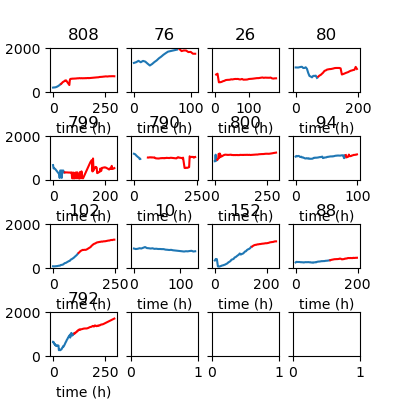

In [50]:
import warnings

warnings.filterwarnings("ignore", category=plt.cbook.mplDeprecation)
plt.close("all")
x = "time_since_begin"
y = "density"
xlabel = "time (h)"
ylabel = "densitu"
logy = False
logx = False
ylim = 0, 2000
num_columns = 4
num_rows = len(select) // num_columns + 1
fig = plt.figure(figsize=(num_columns * 1, num_rows * 1))
gs = fig.add_gridspec(num_rows, num_columns, hspace=1)
axs = gs.subplots(sharex=False, sharey=True)
axs = axs.flatten()
i = 0
for index, row in select.iterrows():
    folder = row["folder_analysis"]
    path_analysis_info = row["path_analysis_info"]
    plate = row["Plate"]
    if os.path.isfile(f"{directory}{path_analysis_info}"):
        ax = axs[i]
        whole_plate_info = pd.read_json(
            f"{directory}{path_analysis_info}", convert_dates=True
        ).transpose()
        whole_plate_info.index.name = "t"
        whole_plate_info.reset_index(inplace=True)
        whole_plate_info["datetime"] = pd.to_datetime(
            whole_plate_info["date"], format="%d.%m.%Y, %H:%M:"
        )
        whole_plate_info["time_since_begin"] = (
            whole_plate_info["datetime"] - min(whole_plate_info["datetime"])
        ) / np.timedelta64(1, "h")
        whole_plate_info["density"] = (
            whole_plate_info["tot_length_study"] / whole_plate_info["area_study"]
        )
        in_study = whole_plate_info.loc[whole_plate_info["out_study"] == 0]
        out_study = whole_plate_info.loc[whole_plate_info["out_study"] == 1]
        if len(in_study) > 0:
            in_study.plot(
                x, y, title=plate, ax=ax, logy=logy, logx=logx, ylim=ylim, legend=False
            )
        if len(out_study) > 0:
            out_study.plot(
                x,
                y,
                title=plate,
                ax=ax,
                color="red",
                logx=logx,
                logy=logy,
                ylim=ylim,
                legend=False,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        i += 1
    else:
        print(folder)
plt.tight_layout(pad=1, w_pad=1, h_pad=1)